<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/AA_GRUPO3/blob/main/Lab04_Pr03_enfermeria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Puestos de enfermería

Una empresa de colocación de trabajadores pretende hacer una aplicación para ser más eficiente en los enfermeros y enfermeras que asignan para cuidados en hogares. Para ello se dispone del archivo csv “enfermeria” con las características de las distintas personas que pueden optar a los puestos. Crear un modelo que agrupe los candidatos y establezca como se relacionan entre ellos jerárquicamente.

1) Utiliza varias configuraciones para el modelo que más se adapte y teniendo en cuenta los tipos
de distancias entre elementos. ¿Cuál es la k del modelo? (1 puntos)

2) Dibuja un dendograma con los clusters obtenidos. Explica alguna de las relaciones interesantes que puedas
encontrar. (1 punto)

#Importación de librerías

In [94]:
import mlxtend
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend import frequent_patterns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as sch


In [95]:
# Lectura de la base de datos
filename = 'enfermeria.csv'
data = pd.read_csv(filename, sep = ',')

data.head(20)

,parents_occupation,childs_nursery,family_form,number_children,housing_conditions,financial_standing,social_conditions,health_conditions,recommendation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
5,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom
6,usual,proper,complete,1,convenient,convenient,problematic,recommended,priority
7,usual,proper,complete,1,convenient,convenient,problematic,priority,priority
8,usual,proper,complete,1,convenient,convenient,problematic,not_recom,not_recom
9,usual,proper,complete,1,convenient,inconv,nonprob,recommended,very_recom


In [96]:
# Revisión de los tipos de datos
print(data.shape)

(12960, 9)


In [97]:
# No hay nan
print(data.info())

# Quitamos los duplicados que tampoco hay
data = data.drop_duplicates()

print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   parents_occupation  12960 non-null  object
 1   childs_nursery      12960 non-null  object
 2   family_form         12960 non-null  object
 3   number_children     12960 non-null  object
 4   housing_conditions  12960 non-null  object
 5   financial_standing  12960 non-null  object
 6   social_conditions   12960 non-null  object
 7   health_conditions   12960 non-null  object
 8   recommendation      12960 non-null  object
dtypes: object(9)
memory usage: 911.4+ KB
None
(12960, 9)


In [98]:
data.value_counts(data['parents_occupation'])

parents_occupation
great_pret     4320
pretentious    4320
usual          4320
dtype: int64

A continuación, procedemos a pasar todas las variables categóricas a numéricas para poder calcular posteriormente las distancias con LabelEncoder.fit_transform que es una función de preprocesamiento de sklearn.

In [99]:
encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = encoder.fit_transform(data[col])

In [100]:
data

,parents_occupation,childs_nursery,family_form,number_children,housing_conditions,financial_standing,social_conditions,health_conditions,recommendation
0,2,3,0,0,0,0,0,2,2
1,2,3,0,0,0,0,0,1,1
2,2,3,0,0,0,0,0,0,0
3,2,3,0,0,0,0,2,2,2
4,2,3,0,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...
12955,0,4,2,3,1,1,2,1,3
12956,0,4,2,3,1,1,2,0,0
12957,0,4,2,3,1,1,1,2,3
12958,0,4,2,3,1,1,1,1,3


Antes de probar con distintas métricas para conseguir el número de clus

In [101]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

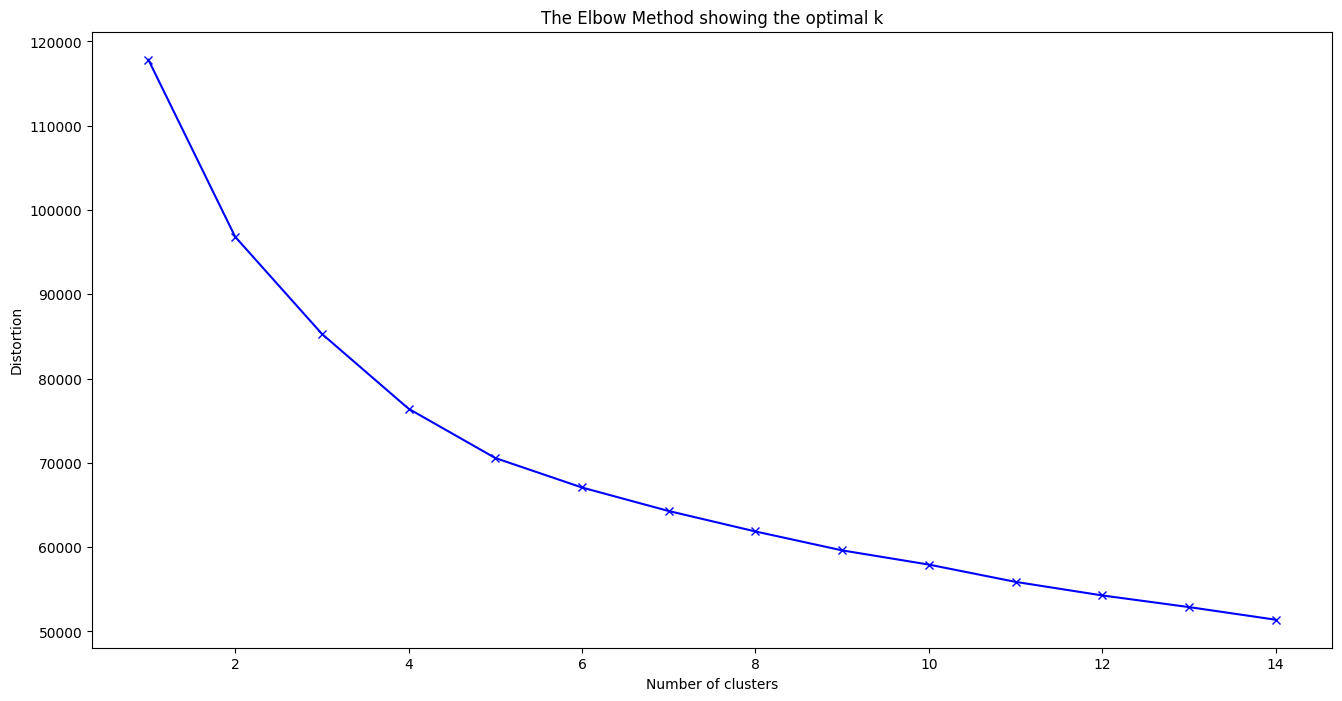

In [102]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Probaremos con 2, 3, 4 y 5 clusters, utilizando las distancias Euclídea y de Manhattan.
Calculadas de esta manera:

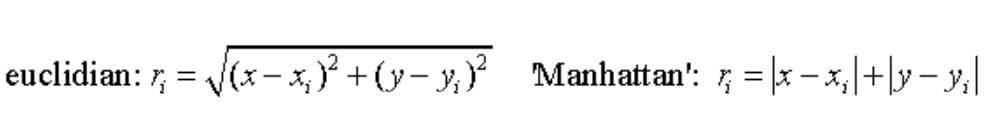


La distancia Euclídea es la única que utilizar el criterio de entrelazamiento ward, por lo que utilizaremos la distancia máxima (complete) para la distancia de Manhattan.

In [103]:
# Número de clusters y métricas a probar
n_clusters = [2, 3, 4, 5]
metricas = ['euclidean', 'manhattan']

# Inicializar lista para almacenar resultados
resultados = []

# Iterar sobre valores de parámetros
for n in n_clusters:
  for m in metricas:
    if m == 'euclidean':
      # Inicialización del modelo
      modelo = AgglomerativeClustering(n_clusters=n, metric=m, linkage='ward')
    else:
      modelo = AgglomerativeClustering(n_clusters=n, metric=m, compute_full_tree=True, linkage='complete')
    # Entrenamos modelo
    modelo.fit(data)
    # Predicción de los clusters
    pred = modelo.fit_predict(data)
    # Calculamos el score
    score = silhouette_score(data, pred)
    # Almacenar resultados en lista
    resultados.append((m, n, pred, score))

Procedemos a ver cúal de los 8 modelos nos devuelve el mejor resultado.

In [104]:
# Vemos los resultados
for resul in resultados:
  print("Métrica:", resul[0])
  print("Número de clusters:", resul[1])
  print("Predicciones:", resul[2])
  print("Score:", resul[3],"\n")

Métrica: euclidean
Número de clusters: 2
Predicciones: [1 1 1 ... 0 0 1]
Score: 0.189307953603608 

Métrica: manhattan
Número de clusters: 2
Predicciones: [0 0 0 ... 1 1 0]
Score: 0.189307953603608 

Métrica: euclidean
Número de clusters: 3
Predicciones: [0 0 0 ... 1 1 0]
Score: 0.17343580251679594 

Métrica: manhattan
Número de clusters: 3
Predicciones: [0 0 0 ... 1 1 2]
Score: 0.11275457972876789 

Métrica: euclidean
Número de clusters: 4
Predicciones: [0 0 0 ... 3 3 0]
Score: 0.15221165581957358 

Métrica: manhattan
Número de clusters: 4
Predicciones: [1 3 3 ... 0 0 2]
Score: 0.06891358776805691 

Métrica: euclidean
Número de clusters: 5
Predicciones: [1 1 1 ... 3 3 4]
Score: 0.14158072504896616 

Métrica: manhattan
Número de clusters: 5
Predicciones: [0 1 1 ... 4 4 2]
Score: 0.10310575151718784 



Observamos que el modelo más óptimo es 2 clusters, utilizando la distancia Euclídea o Manhattan, un mismo valor devuelto (0.189).

Vamos a realizar la gráfica para utilizar el método del codo para reafirmar el resultado o elegir otro valor para la k y crear finalmente nuestro modelo. Hacemos uso del método Kmeans de la librería Sklearn.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

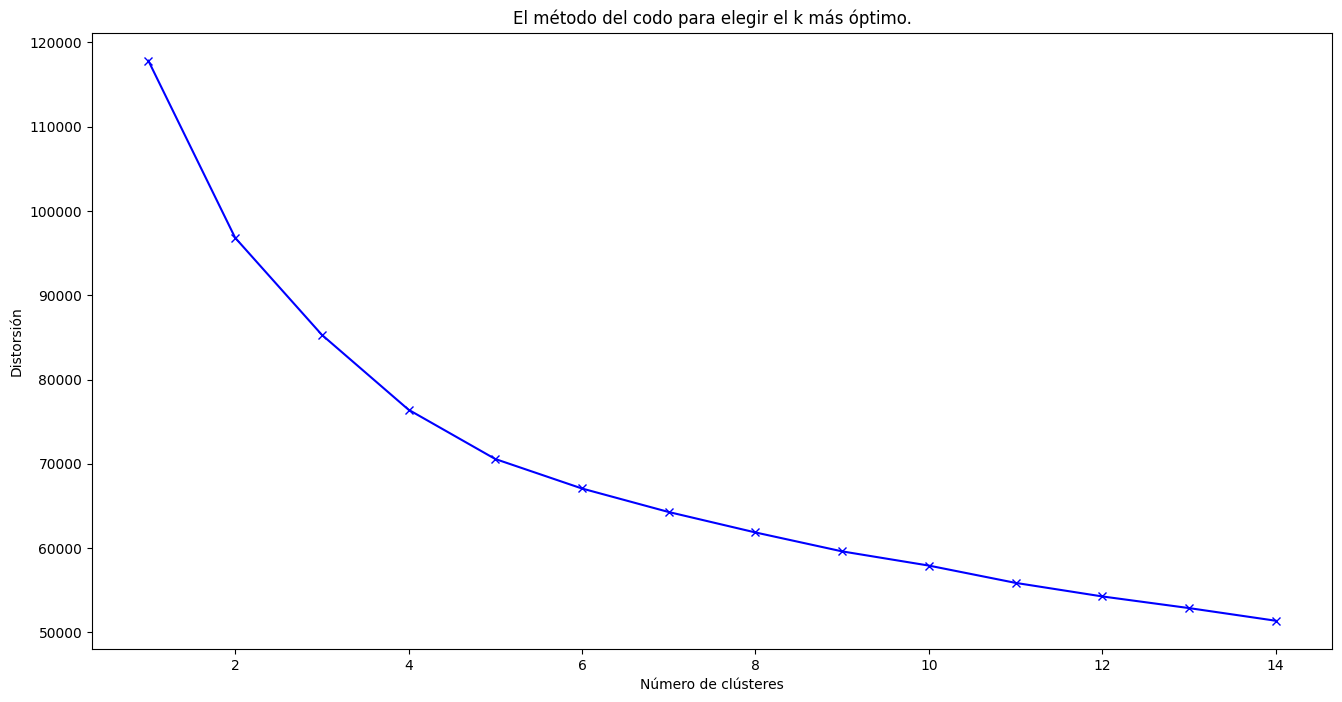

In [105]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

# Gráfica del método del codo
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clústeres')
plt.ylabel('Distorsión')
plt.title('El método del codo para elegir el k más óptimo.')
plt.show()

Vemos que no hay un pico "codo" claro, por lo que vamos a tomar k = 3, de esta manera el análisis de los grupos será más sencillo de interpretar y poder sacar un mayor número de conclusiones.

Utilizaremos la distancia Euclidea para poder utilizar el método 'kmeans' de la librería sklearn.

In [106]:
k = 3
m = 'euclidean'
# Creamos el modelo
modelo_optimo = AgglomerativeClustering(n_clusters=k, affinity=m, linkage='ward')
# Entrenamos el modelo
modelo_optimo.fit(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', n_clusters=3)

Observamos que de los clusters creados, el que más individuos contiene es el 0, mientras que los otros dos están bastante igualados.

In [107]:
# Columna nueva con cluster al que pertenece la fila
data['cluster'] = modelo_optimo.labels_

# Contamos cuantos hay de cada tipo 
data.value_counts(data['cluster'])

cluster
0    8588
1    2306
2    2066
dtype: int64

## 2) Dendograma

Dibujamos el dendograma que contiene las últimas 30 agrupaciones creadas, se pueden diferenciar 3 colores, el verde, el naranja y el azul.

La primera rama que se bifurca del resto es la naranja, posteriormente la verde y es la azul la que une ambas, a diferentes alturas. 

Las alturas quieren decir que la distancia entre dichos clusters es mayor.

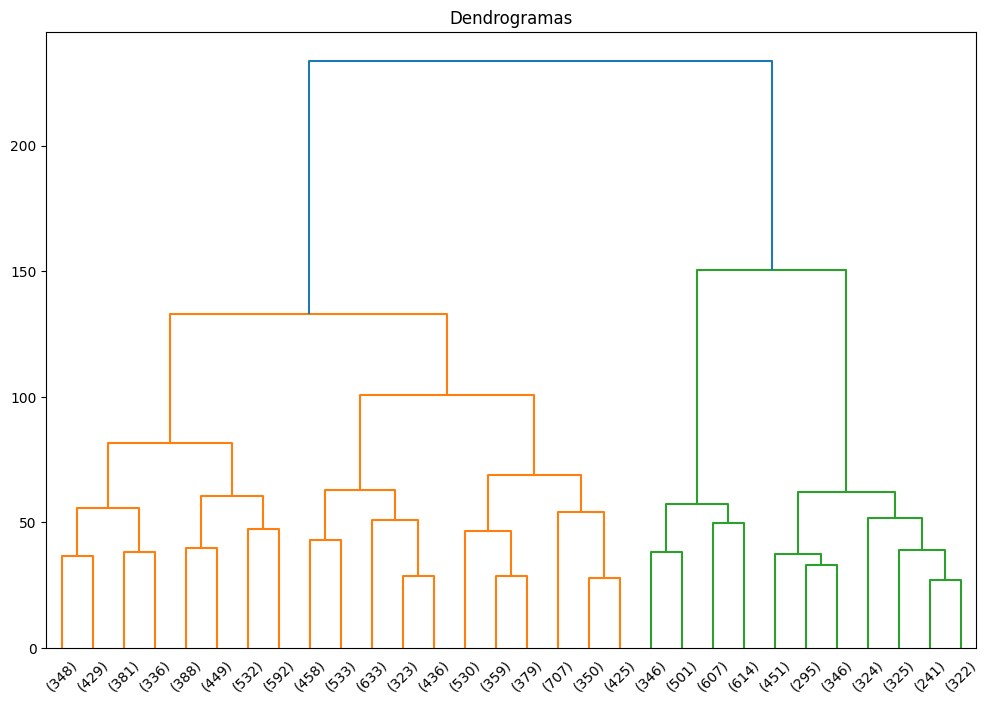

In [108]:
#Bifurcación de los clústeres:
plt.figure(figsize=(12, 8))  
plt.title("Dendrogramas") 
sch.dendrogram(sch.linkage(data, method = 'ward', metric='euclidean'), truncate_mode='lastp', p=30)
plt.show()

Los 30 números representados en el "eje X", muestran el número de individuos que pertenece a cada agrupación. Se puede observar que la distribución es menos uniforme que cuando tomamos 3 clusters.

####Simplificación del dendograma

Ahora, vamos a representar solo los 3 clusters con los que hemos decidido trabajar, para ello pondremos el valor p en 3, el cual mostrará los últimos 3 clusters y el parámetro truncate_mode en 'lastp', truncando el dendograma por los clusters más pequeños.

Es por ello que nos mostrará los últimos 3 clústeres más pequeños, es decir los que tomamos anteriormente.

De esta manera, será más fácil poder interpretar el dendograma.

Realizar esto es muy eficaz a la hora de tener una base de datos muy grande, ya que de esta forma se puede realizar análisis.

Como era de esperar, los que contienen menos individuos son más parecidos que el cluster 0.

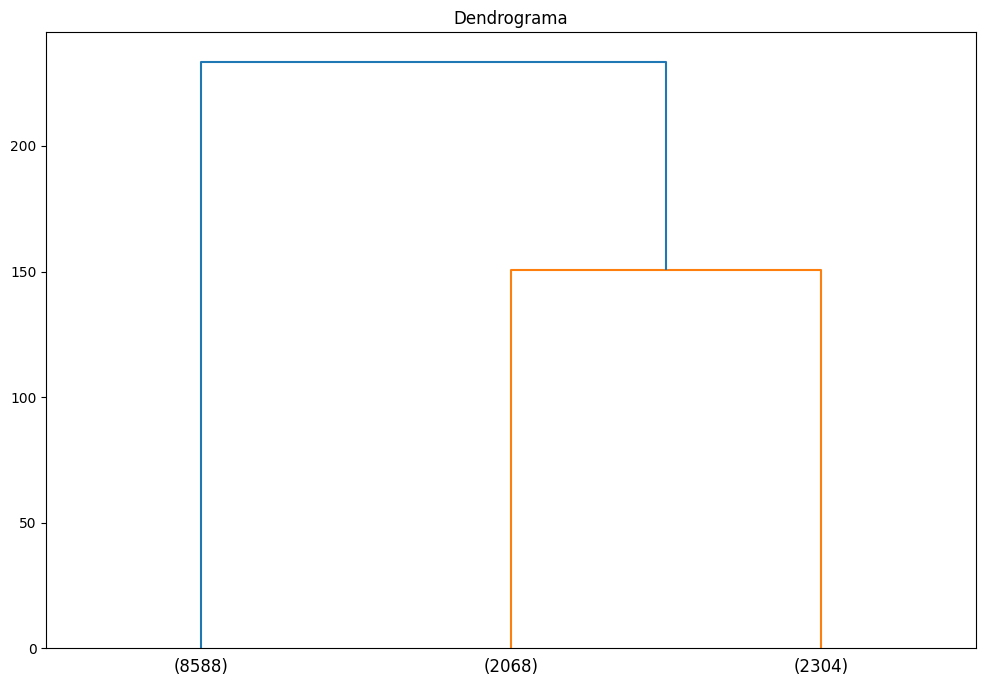

In [112]:
# Los clusters elegidos, k = 3
plt.figure(figsize=(12, 8))  
plt.title("Dendrograma") 
sch.dendrogram(sch.linkage(data, method = 'ward', metric='euclidean'), truncate_mode='lastp', p=3)
plt.show()

### Análisis de resultados

Para poder sacar conclusiones, hay que hacer un estudio de los resultados obtenidos.

Análisis de correlación: Puedes calcular la correlación entre las características de los individuos en un mismo cluster para identificar posibles relaciones. Por ejemplo, puedes utilizar la matriz de correlación para observar si hay características que están fuertemente correlacionadas en un mismo cluster.

In [124]:
# Separamos los datos en clusters

data0 = data[data['cluster'] == 0]
data1 = data[data['cluster'] == 1]
data2 = data[data['cluster'] == 2]

datos = [data0, data1, data2]

In [141]:
# Matriz de correlación
import seaborn as sns

# Calcular la matriz de correlación
for d in datos:
  matriz_correlacion = d.corr()

  # Identificar las correlaciones más fuertes
  correlaciones_fuertes = matriz_correlacion.abs().unstack().sort_values(ascending=False).drop_duplicates()
  print(f"Las correlaciones de los datos del cluster son:")
  print(correlaciones_fuertes)
  print("\n\n")

Las correlaciones de los datos del cluster son:
parents_occupation  parents_occupation    1.000000e+00
health_conditions   recommendation        9.129600e-01
recommendation      parents_occupation    1.562622e-01
parents_occupation  health_conditions     9.241837e-02
childs_nursery      parents_occupation    8.672636e-02
number_children     parents_occupation    4.269554e-02
recommendation      number_children       4.124351e-02
parents_occupation  housing_conditions    3.291197e-02
housing_conditions  recommendation        3.220373e-02
financial_standing  housing_conditions    3.068374e-02
                    parents_occupation    2.726585e-02
                    recommendation        2.667912e-02
health_conditions   number_children       2.606937e-02
family_form         recommendation        2.435664e-02
parents_occupation  family_form           2.380289e-02
family_form         number_children       2.063323e-02
health_conditions   housing_conditions    2.029116e-02
                 

<Axes: >

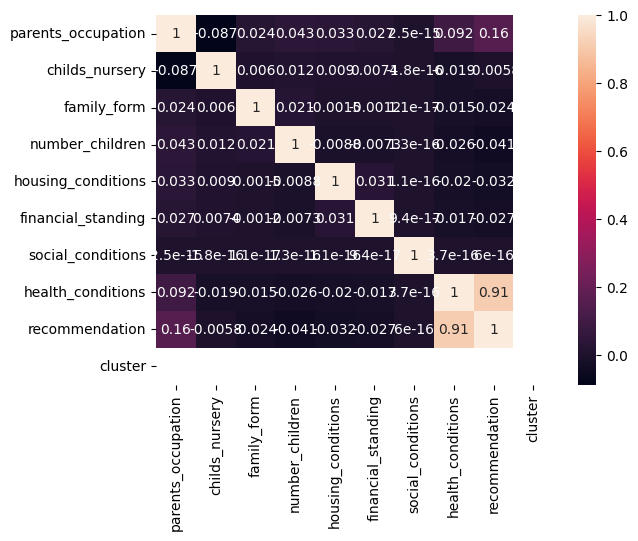

In [136]:
# Visualizar la matriz de correlación de data0
m_c0 = data0.corr()
sns.heatmap(m_c0, annot=True)

<Axes: >

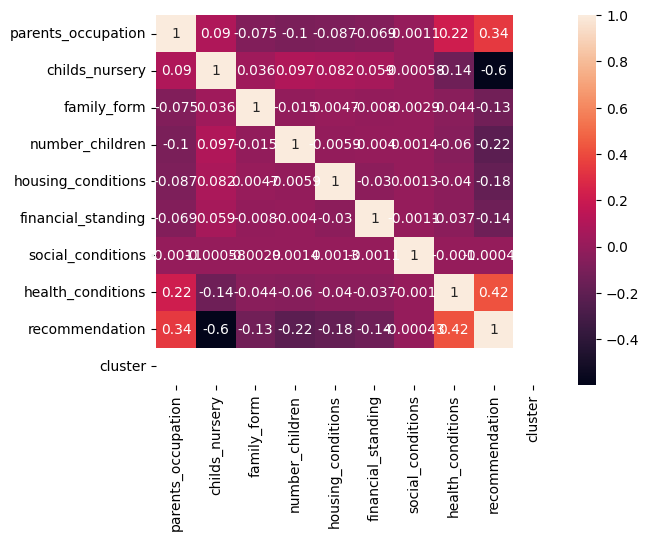

In [137]:
# Visualizar la matriz de correlación de data1
m_c1 = data1.corr()
sns.heatmap(m_c1, annot=True)

<Axes: >

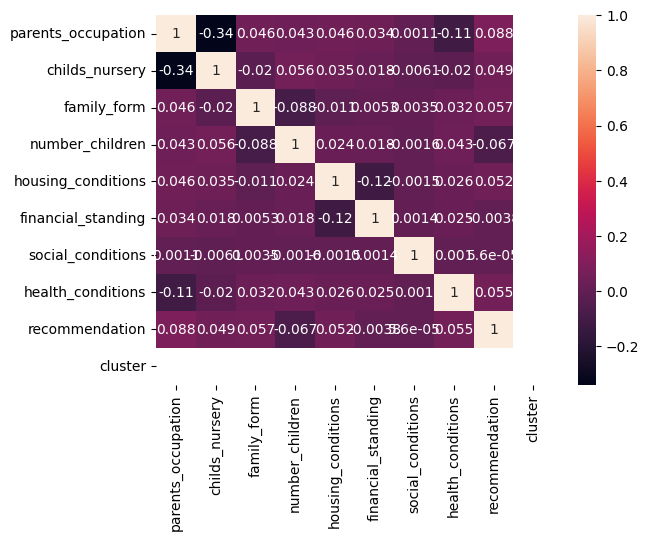

In [138]:
# Visualizar la matriz de correlación de data2
m_c2 = data2.corr()
sns.heatmap(m_c2, annot=True)

In [145]:
# Cálculo de medias de los diferentes parámetros de los diferentes clusteres
mean_std = []
for d in datos:
  for columna in d:
    media = d[columna].mean()
    desviacion = d[columna].std()
    mean_std.append((columna, media, desviacion))

for m in mean_std:
  print("De la columna", m[0], "la media es ", round(m[1], 4), "y la desviación típica es ", round(m[2], 4),".\n")

De la columna parents_occupation la media es  1.1244 y la desviación típica es  0.8026 .

De la columna childs_nursery la media es  1.9923 y la desviación típica es  1.2578 .

De la columna family_form la media es  1.4735 y la desviación típica es  1.1238 .

De la columna number_children la media es  1.4546 y la desviación típica es  1.1232 .

De la columna housing_conditions la media es  0.9739 y la desviación típica es  0.8282 .

De la columna financial_standing la media es  0.487 y la desviación típica es  0.4999 .

De la columna social_conditions la media es  1.0 y la desviación típica es  0.8297 .

De la columna health_conditions la media es  0.7781 y la desviación típica es  0.8573 .

De la columna recommendation la media es  0.4972 y la desviación típica es  0.5005 .

De la columna cluster la media es  0.0 y la desviación típica es  0.0 .

De la columna parents_occupation la media es  0.882 y la desviación típica es  0.8425 .

De la columna childs_nursery la media es  3.4545 y l